## RFM分析

RFM分析は、顧客の購買行動を分析しマーケティング戦略を策定するツールで、「Recency（最終購入日）」、「Frequency（購入頻度）」、「Monetary（購入金額）」の3つの指標にもとづいています。


最終購入日は顧客が最後に購入してからの時間、購入頻度は一定期間内の購入回数、購入金額は過去の総購入金額を示します。これらを分析して顧客をセグメントに分類し、セグメントごとにカスタマイズされたマーケティング戦略を立てることができます。

特に小売りやECサイトなどで有効で、顧客満足度の向上、売上増加、顧客ロイヤルティの強化につなげることができます。

この記事ではユーザーがアイテムを購入した履歴であるダミーのデータベースをポアソン分布とガンマ分布を利用して作成します。なぜそれらの分布で購入履歴を作成するかは 「確率思考の戦略論 USJでも実証された数学マーケティングの力」 を参照してください。
また、ユーザーのダミーデータを作成するために、ここではFakerというライブラリを利用します。

これらのダミーデータに対してRFMを分析を行ってみます。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/rec/mkt/04/04_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/rec/mkt/04/04_nb.ipynb)


### 実行環境
OSはmacOSです。LinuxやUnixのコマンドとはオプションが異なりますので注意してください。

In [6]:
!sw_vers

ProductName:		macOS
ProductVersion:		13.5.1
BuildVersion:		22G90


In [7]:
!python -V

Python 3.9.17


pandasのテーブルを見やすいようにHTMLのテーブルにCSSの設定を行います。

In [63]:
from IPython.core.display import HTML

style = """
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

    .dataframe thead th {
        text-align: left;
        padding: 5px;
    }

    .dataframe tbody tr th {
        vertical-align: top;
        padding: 5px;
    }

    .dataframe tbody tr:hover {
        background-color: #ffff99;
    }

    .dataframe {
        background-color: white;
        color: black;
        font-size: 16px;
    }

</style>
"""
HTML(style)

基本的なライブラリをインポートし watermark を利用してそのバージョンを確認しておきます。
ついでに乱数のseedの設定をします。

In [64]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [74]:
import numpy as np
import pandas as pd
import scipy

import calendar
import random

import matplotlib.pyplot as plt

import faker
from faker import Faker


seed = 123
random_state = 123

random.seed(seed)
np.random.seed(seed)


from watermark import watermark

print(watermark(python=True, watermark=True, iversions=True, globals_=globals()))

Python implementation: CPython
Python version       : 3.9.17
IPython version      : 8.17.2

pandas    : 2.0.3
matplotlib: 3.8.1
sqlite3   : 2.6.0
numpy     : 1.25.2
scipy     : 1.11.2
faker     : 23.2.0

Watermark: 2.4.3



## ダミーの購買履歴の作成

データベースはSQLiteというファイルベースの軽量なデータベースを利用します。また、SQLiteを操作するために、sqlite3というモジュールを利用してSQLを実行します。

ダミーデータは、以下のER図に基づいて作成します。ユーザーテーブル、アイテムテーブル、そして、購買履歴テーブルを作成します。ER図などについてはデータベースの設計に関する書物を参照してください。


![png](04_nb_files_local/dummy.png)

ダミーデータを格納するデータベースはSQLiteを利用します。また、PythonからSQLiteへの操作はsqlite3を利用します。

Pythonのsqlite3モジュールは、ファイルベースのSQLiteデータベースを操作するための組み込みライブラリです。sqlite3を利用する事で、データベースの作成、データの挿入、更新、削除、クエリの実行などが簡単にできます。

SQLiteはファイルベースであり、サーバーが不要です。そのため、管理がほとんど不要であり、単一ファイルにデータを格納するため移動やバックアップが容易です。また、ACIDトランザクションと多くのSQL標準に対応しています。

SQLiteは軽量でファイルベースのデータベースであり、大規模トランザクションや高同時アクセスには向いていません。これは、複雑なクエリや大量の読み書きによるパフォーマンス問題と、ネットワーク経由での分散アクセスに対する制限があるためです。SQLiteは中小規模のデータベースやローカル環境に最適です。

本記事では、SQLiteに仮想的なデータベースをPythonのsqlite3モジュールを作成します。

### データベースと各テーブルの作成

最初に、SQLiteのファイルを作成します。``test\_data.db'' という名前でファイルのデータベースを作成します。繰り返しますが、SQLiteはファイルベースのデータベースなので、現在のディレクトリの直下にPythonのosモジュールを利用してテキストファイルと同じように作成します。

このデータベースに、三つのテーブルを作成します。

一つ目がユーザーの情報を格納する、Usersテーブルです。

二つ目がアイテムの情報を格納する、Itemsテーブルです。

三つ目が購買履歴を情報を格納する、PurchaseHistoryテーブルです。

UsersテーブルはPrimary KeyとしてUserIDを持ち、ユーザーの名前と、誕生日、職業が格納されます。

Itemsテーブルには、Primary Keyとして、ItemIDを持ち、アイテムの名前とその値段を格納します。

PurchaseHistoryテーブルは購入したユーザーとアイテムのID、購入した量と日時を格納します。


In [44]:
import os
import sqlite3

db_file_name = "test_data.db"

# 古いファイルが存在すれば削除
if os.path.isfile(db_file_name):
    os.remove(db_file_name)

with sqlite3.connect(db_file_name) as conn:
    cur = conn.cursor()

    # Users テーブルの作成
    cur.execute(
        """
    CREATE TABLE Users (
        UserID INTEGER PRIMARY KEY AUTOINCREMENT,
        Name TEXT NOT NULL,
        Birthday TEXT,
        Job TEXT
    );
    """
    )

    # Items テーブルの作成
    cur.execute(
        """
    CREATE TABLE Items (
        ItemID INTEGER PRIMARY KEY AUTOINCREMENT,
        Name TEXT,
        Price INTEGER
    );
    """
    )

    # PurchaseHistory テーブルの作成
    cur.execute(
        """
    CREATE TABLE PurchaseHistory (
        PurchaseID INTEGER PRIMARY KEY AUTOINCREMENT,
        UserID INTEGER NOT NULL,
        ItemID INTEGER NOT NULL,
        PurchaseDate TEXT NOT NULL,
        Quantity INTEGER NOT NULL,
        FOREIGN KEY (UserID) REFERENCES Users(UserID),
        FOREIGN KEY (ItemID) REFERENCES Items(ItemID)
    );
    """
    )

    cur.close()
    conn.commit()

テーブルが実際に作成されているか確認します。

In [45]:
with sqlite3.connect(db_file_name) as conn:
    cur = conn.cursor()

    # テーブル一覧を取得
    cur.execute(
        """
        SELECT name FROM sqlite_master WHERE type='table';
    """
    )

    table_list = cur.fetchall()

    cur.close()

for i, table in enumerate(table_list):
    print(f"{i + 1}. {table[0]}")

1. Users
2. sqlite_sequence
3. Items
4. PurchaseHistory


SQLite3 の sqlite\_master テーブルはSQLiteデータベースにおけるメタデータを収めたシステムテーブルであり、データベース内のすべてのテーブル、インデックス、ビュー、トリガー等のスキーマ情報を保持しています。

このsqlite\_masterテーブルには、以下のようなカラムが存在します。


- type: このエントリーがどのような種類のオブジェクトを指すのかを示します。例としては、table, index, view, trigger などがあります。
- name: ここにはオブジェクト（テーブル、インデックス、ビュー、トリガー）の名称が記載されています。
- tbl\_name: このカラムは特定のオブジェクトが関連づけられているテーブルの名称を示します。インデックスやトリガーの場合、それらが紐づいているテーブルの名前がここに入ります。
- sql: このカラムには、オブジェクトを生成した際のSQL文が格納されており、テーブル、インデックス、ビュー、トリガーの作成に用いられたCREATE文が含まれています。


sqlite\_masterテーブルにクエリを実行することで、データベースの構造や特定のテーブルやオブジェクトに関する情報を容易に得ることができます。


In [46]:
with sqlite3.connect(db_file_name) as conn:
    sqlite_master_df = pd.read_sql_query("SELECT * FROM sqlite_master", conn)

sqlite_master_df.head()

,type,name,tbl_name,rootpage,sql
0,table,Users,Users,2,CREATE TABLE Users (\n UserID INTEGER P...
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,Items,Items,4,CREATE TABLE Items (\n ItemID INTEGER P...
3,table,PurchaseHistory,PurchaseHistory,5,CREATE TABLE PurchaseHistory (\n Purcha...


このテーブルは読み取りのみ可能で、直接編集することはできません。データベースのスキーマに変更が加えられると、sqlite\_masterテーブルも自動的に更新されることになります。


### ユーザーテーブルとアイテムテーブルの作成

ユーザーのダミーデータを作成するために、ここではFakerというライブラリを利用します。

Fakerは、ソフトウェアテスト、機械学習の学習データ生成、データの匿名化など様々な場面で利用される便利なツールです。

名前、住所、電話番号、メールアドレス、パスワードなどの多様なダミーデータを生成でき、これによりソフトウェアのテストを効率化したり、機械学習モデルの学習精度を向上させたり、個人情報の保護を強化することができます。

具体的な利用例としては、Webアプリケーションのテスト、機械学習モデルの学習、データベーステスト、顧客データの匿名化などがあります。

ここでは、Fakerを利用して、ユーザー名と誕生日、仕事をランダムに生成します。また、アイテムについても歯磨き粉や歯ブラシなどを作成します

また、作成するデータベースのユーザー数を100、アイテム数を3と設定します。

In [47]:
Faker.seed(seed)
fake = Faker("jp-JP")

user_num = 100
item_num = 3


with sqlite3.connect(db_file_name) as conn:
    cur = conn.cursor()

    # ユーザーテーブルの作成
    for _ in range(user_num):
        name = fake.name()
        birthday = fake.date_of_birth()
        job = fake.job()

        cur.execute(
            f"INSERT INTO Users (Name, Birthday, Job) VALUES (?, ?, ?);",
            (name, birthday, job),
        )

    # アイテムテーブルの作成
    cur.execute(f"INSERT INTO Items (Name, Price) VALUES (?, ?);", ("歯ブラシ", 100))
    cur.execute(f"INSERT INTO Items (Name, Price) VALUES (?, ?);", ("歯磨き粉", 200))
    cur.execute(f"INSERT INTO Items (Name, Price) VALUES (?, ?);", ("柔軟剤", 500))

    cur.close()
    conn.commit()


### 購買履歴

次に各ユーザーの購入履歴を作成します。

#### ポアソン分布

ポアソン分布は、ある一定時間に平均 $\lambda$ 回起こる離散的なイベントの数をモデル化するために使われる確率分布です。

ここでは、あるユーザーがあるアイテムを一定期間に$\lambda$回購入すると仮定しモデルを作成します。

ポアソン分布は、さまざまな現象のモデル化に使用されます。

たとえば、一定期間内に特定の地域で発生する交通事故の数、工場の生産ラインにおいて一定時間に生じる不良品の数、一定時間内にコールセンターにかかってくる電話の数をモデル化する際に利用されます。

ポアソン分布を式で示すと以下のようになります。

$$
\begin{equation}
    P(X=k)= \frac{e^{-\lambda} \lambda^k}{k !}
\end{equation}
$$


ポアソン分布の期待値$E[X]$は、すべての可能な$k$値にわたる確率質量関数の重み付け和です。
ポアソン分布は確率変数として整数$k$をもつ非連続な確率分布です。

$$
\begin{equation}
    \begin{aligned}
        E[X] & =\sum_{k=0}^{\infty} k \cdot P(X=k)=\sum_{k=0}^{\infty} k \cdot \frac{e^{-\lambda} \lambda^k}{k !} =\sum_{k=1}^{\infty} \frac{e^{-\lambda} \lambda^k}{(k-1) !} \\
             & =\lambda e^{-\lambda} \sum_{k=1}^{\infty} \frac{\lambda^{k-1}}{(k-1) !} =\lambda e^{-\lambda} \cdot e^{\lambda} = \lambda
    \end{aligned}
\end{equation}
$$

したがって、ポアソン分布の平均 (期待値) は $\lambda$ に等しくなります。

scipyライブラリを利用して、$\lambda$に対してポアソン分布がどのように変化するかグラフで可視化してみます。

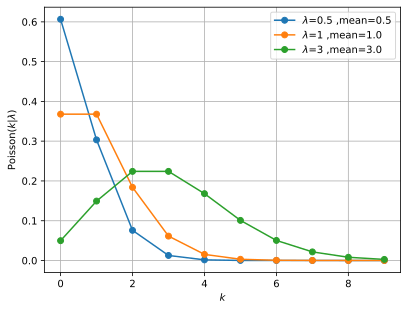

In [78]:
from scipy.stats import poisson

for _lambda in [0.5, 1, 3]:
    x = np.arange(10)
    mean, var, skew, kurt = poisson.stats(_lambda, moments="mvsk")
    plt.plot(x, poisson.pmf(x, _lambda), marker="o", label=f"$\\lambda$={_lambda} ,mean={mean}")

plt.xlabel("$k$")
plt.ylabel("$\\text{Poisson}(k|\lambda)$")
plt.grid()
plt.legend()
plt.show()

$\lambda$ が大きくなるにつれて分布の山が右の方へ移動していくことがわかります。
平均が$\lambda$なので当然のことですが…

#### ガンマ分布

次に、あるユーザーが一定期間に購入する平均値$\lambda$自体にある確率分布を仮定します。

すなわち、あるアイテムを購入するユーザーはたくさんいて、ユーザーAは$\lambda_1$の平均的な購入回数を持ち、ユーザーBは$\lambda_2$を持つと仮定できます。本記事では、この$\lambda$の分布をガンマ分布と仮定します。

なぜ$\lambda$の分布をガンマ分布と仮定するかは参考文献「確率思考の戦略論 USJでも実証された数学マーケティングの力」に詳細に書かれています。

ガンマ分布は$x \geqq 0$で定義される連続的な確率分布です。二つのパラメタ$\alpha, \beta$を持ち、その積$\alpha \times \beta$が平均値となります。以下のように定義されます。

$$
\begin{equation}
    \operatorname{Gamma}(x \mid \alpha, \beta)=\frac{x^{\alpha-1} e^{-\frac{x}{\beta}}}{\Gamma(\alpha) \beta^\alpha}
\end{equation}
$$

ここで、$\Gamma(\alpha)$はガンマ関数で以下のように定義されます。

$$
\begin{equation}
    \Gamma(\alpha)=\int_0^{\infty} x^{\alpha-1} e^{-x} d x \quad a>0
\end{equation}
$$

scipyを利用して、二つのパラメタを平均を一定にして変化させたグラフを示します。平均値は2と設定しています。

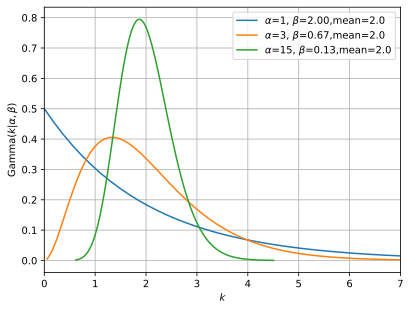

In [49]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gamma

for a, b in zip([1, 3, 15], [2, 2 / 3, 2 / 15]):
    x = np.linspace(gamma.ppf(0.0001, a, scale=b), gamma.ppf(0.9999, a, scale=b), 100)
    mean, var, skew, kurt = gamma.stats(a, scale=b, moments="mvsk")
    plt.plot(x, gamma.pdf(x, a, scale=b), label=f"$\\alpha$={a}, $\\beta$={b:.2f},mean={mean}")

plt.xlim([0, 7])
plt.xlabel("$k$")
plt.ylabel("$\\text{Gamma}(k|\\alpha, \\beta)$")
plt.grid()
plt.legend()
plt.show()

平均は同じですが、$\alpha$と$\beta$の値によって形状が大きく異なることがわかります。

#### 購入履歴の作成

現在日時を設定し、その60ヶ月前の購入履歴を作成します。
購入した商品の個数が0の場合はデータベースにinsert処理はしません。

各アイテムについて、ガンマ分布の各パラメタを設定します。そのガンマ分布から各ユーザーの平均的な購入回数である$\lambda$を生成します。
その$\lambda$を持つポアソン分布から各月における各商品の購入個数を生成します。それが0の場合、ユーザーは何も購入しなかったという結果になります。

以下のコードでは月ごとの購入個数をシミュレートしており、具体的な日付についてはランダムに生成しています。

In [79]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gamma
from scipy.stats import poisson

import datetime
from dateutil.relativedelta import relativedelta

# 購入履歴の数
purchase_history_size = 60

# 仮の現在日付の設定
current_date = datetime.date(2024, 7, 1)

# 現在から60ヶ月前までの日付のリスト
datetime_list = [current_date - relativedelta(months=i + 1) for i in range(purchase_history_size)]

# 三つの商品のガンマ分布のパラメタ
# - 歯ブラシ
#   - alpha : 1
#   - bata  : 1
# - 歯磨き粉
#   - alpha : 3
#   - bata  : 1.5 / 3
# - 柔軟剤
#   - alpha : 5
#   - bata  : 0.5 / 5

gamma_a_list = [1, 3, 5]
gamma_b_list = [1, 1.5 / 3, 0.5 / 5]

with sqlite3.connect(db_file_name) as conn:
    cur = conn.cursor()

    # 各商品に対して購買履歴を作成
    for a, b, _item_id in zip(gamma_a_list, gamma_b_list, range(1, item_num + 1)):

        # それぞれの商品をユーザーが購入する個数を計算
        # 各ユーザー分のlambdaをガンマ分布から乱数を生成
        lambda_list = gamma.rvs(a, scale=b, size=user_num, random_state=random_state)

        # 各ユーザーごとに設定されたlambdaを持つポアソン分布から乱数を生成
        for _lambda, _user_id in zip(lambda_list, range(1, user_num + 1)):

            # ポアソン分布から乱数の生成
            history_list = poisson.rvs(_lambda, size=purchase_history_size, random_state=random_state)

            for _created_at, _history in zip(datetime_list[::-1], history_list[::-1]):

                # 購入された商品の個数が1個以上であれば、データベースにINSERT
                if _history > 0:
                    _year = pd.to_datetime(_created_at).year
                    _month = pd.to_datetime(_created_at).month
                    _random_day = random.choice([i + 1 for i in range(calendar.monthrange(_year, _month)[1])])

                    # 年は固定で、日付だけランダムに設定
                    _random_created_at = f"{_year}-{_month}-{_random_day}"

                    # 購入履歴をデータベースに insert
                    cur.execute(
                        f"INSERT INTO PurchaseHistory (UserID, ItemID, Quantity, PurchaseDate) VALUES (?, ?, ?, ?);",
                        (_user_id, _item_id, int(_history), _random_created_at),
                    )

    cur.close()
    conn.commit()

ユーザーテーブルの中身を確認します。

In [51]:
with sqlite3.connect(db_file_name) as conn:
    users_df = pd.read_sql_query("SELECT * FROM Users", conn).set_index("UserID", drop=True)

users_df.head()

,Name,Birthday,Job
UserID,,,
1,渡辺 康弘,1955-05-14,イラストレーター
2,小林 英樹,1946-08-29,YouTuber
3,高橋 太一,1973-03-13,大学教授
4,高橋 涼平,1958-09-25,医師
5,鈴木 花子,1993-01-15,イラストレーター


アイテムテーブルの中身を確認します。

In [52]:
with sqlite3.connect(db_file_name) as conn:
    items_df = pd.read_sql_query("SELECT * FROM Items", conn).set_index("ItemID", drop=True)

items_df.head()

,Name,Price
ItemID,,
1,歯ブラシ,100
2,歯磨き粉,200
3,柔軟剤,500


購買履歴テーブルの中身を確認します。

購入IDに対して、どのユーザーが何を何個、いつ購入したのか記録されています。また、現在日時から何日前に購入したのかという情報も記録しています。

In [65]:
with sqlite3.connect(db_file_name) as conn:
    purchase_history_df = pd.read_sql_query("SELECT * FROM PurchaseHistory", conn).set_index("PurchaseID", drop=True)

purchase_history_df.PurchaseDate = pd.to_datetime(purchase_history_df.PurchaseDate)
purchase_history_df["diff_days"] = purchase_history_df.PurchaseDate.apply(
    lambda x: (pd.to_datetime(current_date) - x).days
)
purchase_history_df.head()

,UserID,ItemID,PurchaseDate,Quantity,diff_days
PurchaseID,,,,,
1,1,1,2019-07-02,3,1826
2,1,1,2019-08-09,1,1788
3,1,1,2019-09-03,2,1763
4,1,1,2019-10-25,3,1711
5,1,1,2019-12-14,2,1661


groupbyを利用して、各ユーザーが各アイテムをどれほどの個数を購入しているか確認します。

購入数の平均値と標準偏差、個数を示します。

In [67]:
purchase_history_df.groupby(["UserID", "ItemID"])["Quantity"].agg(["mean", "std", "count"]).head(15)

mean       std  count
UserID ItemID                           
1      1       1.583333  0.767237     48
       2       1.250000  0.440959     28
       3       1.125000  0.353553      8
2      1       1.066667  0.258199     15
       2       2.491228  1.297288     57
       3       1.310345  0.470824     29
3      1       1.125000  0.353553      8
       2       1.406250  0.559918     32
       3       1.066667  0.258199     15
4      1       1.344828  0.483725     29
       2       3.372881  1.400718     59
       3       1.371429  0.546955     35
5      1       1.653061  0.751416     49
       2       1.166667  0.408248      6
       3       1.000000  0.000000      3

## RFM分析

作成したダミーのデータベースを元にRFM分析を具体的に実行します。

最終購入日（Recency）：顧客が最後にいつ購入したのか（最終購入日からの経過時間が短い顧客を高く評価）
購入頻度（Frequency）：顧客が何回購入したのか（回数の多い顧客を高く評価）
購入金額（Monetary）：顧客が購入した金額合計（金額の高い顧客を高く評価）

1. Recency (最終購入日): 顧客が最後に購入した日からの経過日数。最近購入した顧客は再購入する可能性が高いと考えられます。
2. Frequency (購入頻度): 一定期間内に顧客が行った購入回数。頻繁に購入する顧客は忠実であると見なされ、より価値があるとされます。
3. Monetary (購入金額): 顧客による一定期間内の総購入金額。高い購入金額の顧客はより価値が高いとされます。

これらの指標を用いて、顧客をさまざまなグループに分類し、それぞれに合ったマーケティング戦略を立てます。例えば、最近購入していないが過去に頻繁に購入していた顧客には、再購入を促すような特別なオファーを提供することが考えられます。

RFM分析は、特にリピート購入が重要なビジネスモデルにおいて、顧客の行動をより深く理解し、効果的なカスタマイズされたコミュニケーションを行うのに有効な方法です。この分析を通じて、マーケティングのROI（投資利益率）を高め、顧客満足度を向上させることができます。

### Receny

In [68]:
target_ItemID = 3

recnecy_df = (
    purchase_history_df.sort_values(by=["UserID", "ItemID", "PurchaseDate"])
    .groupby(["UserID", "ItemID"])
    .tail(1)
    .reset_index(drop=True)[["UserID", "ItemID", "diff_days"]]
)

recnecy_df = recnecy_df.rename(columns={"diff_days": "recency"})
recnecy_df.head()

,UserID,ItemID,recency
0,1,1,1
1,1,2,29
2,1,3,210
3,2,1,126
4,2,2,26


### Frequency

2. Frequency (購入頻度): 一定期間内に顧客が行った購入回数。頻繁に購入する顧客は忠実であると見なされ、より価値があるとされます。

In [69]:
frequency_df = (
    purchase_history_df[purchase_history_df.diff_days < 100]
    .groupby(["UserID", "ItemID"])
    .Quantity.agg(["count"])
    .reset_index()
)

frequency_df = frequency_df.rename(columns={"count": "frequency"})
frequency_df.head()

,UserID,ItemID,frequency
0,1,1,2
1,1,2,2
2,2,2,3
3,2,3,2
4,3,2,2


### Monetary

購入金額（Monetary）：顧客が購入した金額合計（金額の高い顧客を高く評価）

3. Monetary (購入金額): 顧客による一定期間内の総購入金額。高い購入金額の顧客はより価値が高いとされます。


In [70]:
monetary_df = pd.merge(purchase_history_df, items_df, on="ItemID", how="left")
monetary_df["total"] = monetary_df.apply(lambda x: x.Quantity * x.Price, axis=1)
monetary_df = monetary_df[monetary_df.diff_days < 100].groupby(["UserID", "ItemID"]).total.agg(["sum"]).reset_index()

monetary_df = monetary_df.rename(columns={"sum": "monetary"})
monetary_df.head()

,UserID,ItemID,monetary
0,1,1,300
1,1,2,400
2,2,2,2000
3,2,3,1000
4,3,2,400


### RFM分析

In [71]:
_temp = pd.merge(recnecy_df, frequency_df, on=["UserID", "ItemID"], how="left").fillna(0)
rfm_df = pd.merge(_temp, monetary_df, on=["UserID", "ItemID"], how="left").fillna(0)
rfm_df.head()

,UserID,ItemID,recency,frequency,monetary
0,1,1,1,2.0,300.0
1,1,2,29,2.0,400.0
2,1,3,210,0.0,0.0
3,2,1,126,0.0,0.0
4,2,2,26,3.0,2000.0


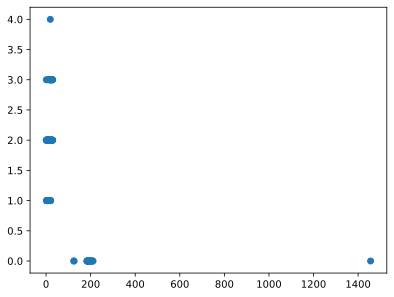

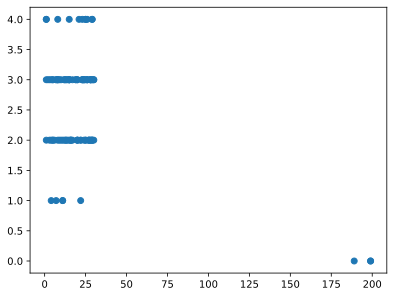

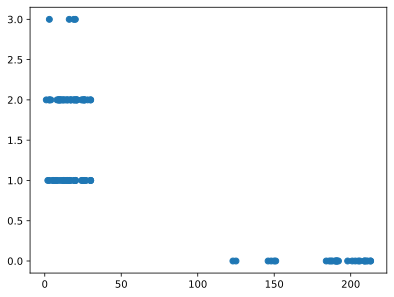

In [59]:
plt.scatter(x=rfm_df[rfm_df.ItemID == 1].recency, y=rfm_df[rfm_df.ItemID == 1].frequency)
plt.show()
plt.scatter(x=rfm_df[rfm_df.ItemID == 2].recency, y=rfm_df[rfm_df.ItemID == 2].frequency)
plt.show()
plt.scatter(x=rfm_df[rfm_df.ItemID == 3].recency, y=rfm_df[rfm_df.ItemID == 3].frequency)
plt.show()

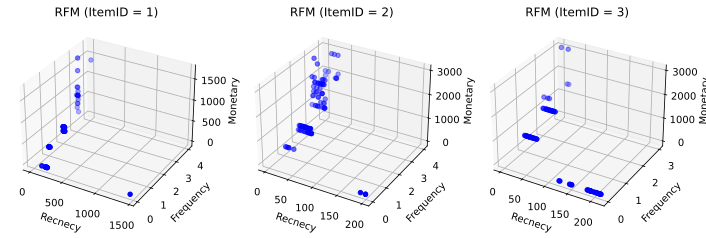

In [60]:
# plt.scatter(x=, y=rfm_df[rfm_df.item_id == 1].frequency)

# import japanize_matplotlib
# import seaborn as sns

# sns.set(font="IPAexGothic")

fig = plt.figure(figsize=(12, 8))

###################################################
ax1 = fig.add_subplot(131, projection="3d")

target_ItemID = 1

_rfm_df = rfm_df[rfm_df.ItemID == target_ItemID]
x = _rfm_df.recency
y = _rfm_df.frequency
z = _rfm_df.monetary

ax1.scatter(x, y, z, s=20, color="blue", label="RFM analysis")

ax1.set_title(f"RFM (ItemID = {target_ItemID})")
ax1.set_xlabel("Recnecy")
ax1.set_ylabel("Frequency")
ax1.set_zlabel("Monetary")

# ax1.legend()

###################################################
ax2 = fig.add_subplot(132, projection="3d")

target_ItemID = 2

_rfm_df = rfm_df[rfm_df.ItemID == target_ItemID]
x = _rfm_df.recency
y = _rfm_df.frequency
z = _rfm_df.monetary

ax2.scatter(x, y, z, s=20, color="blue", label="RFM analysis")

ax2.set_title(f"RFM (ItemID = {target_ItemID})")
ax2.set_xlabel("Recnecy")
ax2.set_ylabel("Frequency")
ax2.set_zlabel("Monetary")

# ax2.legend()


###################################################
ax3 = fig.add_subplot(133, projection="3d")

target_ItemID = 3

_rfm_df = rfm_df[rfm_df.ItemID == target_ItemID]
x = _rfm_df.recency
y = _rfm_df.frequency
z = _rfm_df.monetary

ax3.scatter(x, y, z, s=20, color="blue", label="RFM analysis")

ax3.set_title(f"RFM (ItemID = {target_ItemID})")

ax3.set_xlabel("Recnecy")
ax3.set_ylabel("Frequency")
ax3.set_zlabel("Monetary")

# ax3.legend()


plt.show()

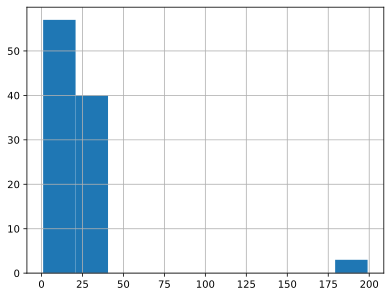

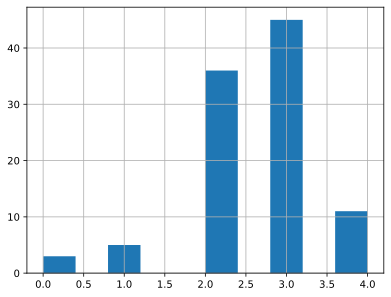

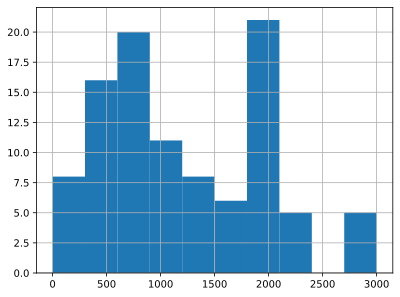

In [61]:
target_ItemID = 2
rfm_df[rfm_df.ItemID == target_ItemID].recency.hist()
plt.show()
rfm_df[rfm_df.ItemID == target_ItemID].frequency.hist()
plt.show()
rfm_df[rfm_df.ItemID == target_ItemID].monetary.hist()
plt.show()

## 結論

## 参考文献

1. 確率思考の戦略論 USJでも実証された数学マーケティングの力